# Data sampling and Image size reshaping

## Imports

In [27]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, classification_report
import pandas as pd
from keras.callbacks import Callback
from livelossplot import PlotLossesKeras
from IPython.display import clear_output

## Reading statistics

In [28]:
stats_file = "image_dimensions.csv"
#stats_file = "/kaggle/input/image-dimensions/image_dimensions.csv"
stats = pd.read_csv(stats_file)
#stats = pd.read_csv("image_dimensions.csv")
stats.set_index("Unnamed: 0", inplace=True)
stats.index.name = None
stats

,widths,heights
count,2801.000000,2801.000000
mean,602.956444,647.924313
std,415.799480,446.639298
min,106.000000,108.000000
25%,313.000000,383.000000
50%,546.000000,590.000000
75%,800.000000,826.000000
max,7264.000000,6017.000000
median,546.000000,590.000000


## Helper functions

In [29]:
median_width = int(stats.loc["median", "widths"])
median_height = int(stats.loc["median", "heights"])

In [30]:
def build_model(width, height, data_augmentation=None):
    model = keras.Sequential()
    model.add(layers.InputLayer(shape=(width, height, 3)))

    if data_augmentation:
        model.add(data_augmentation)

    model.add(layers.Rescaling(1./255))
    model.add(layers.Conv2D(32, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(64, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(128, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(256, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(256, 3, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

model = build_model(median_width, median_height)
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 546, 590, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 544, 588, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 272, 294, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 270, 292, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 135, 146, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 133, 144, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 66, 72, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 70, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 32, 35, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 30, 33, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 253440)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │       253,441 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,231,937 (4.70 MB)

 Trainable params: 1,231,937 (4.70 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
def load_dataset(base_dir, painters, width, height, batch_size=16, interpolation="bilinear"):
    train_dataset = image_dataset_from_directory(
        f'{base_dir}/train',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    validation_dataset = image_dataset_from_directory(
        f'{base_dir}/validation',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    test_dataset = image_dataset_from_directory(
        f'{base_dir}/test',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    return train_dataset, validation_dataset, test_dataset

In [33]:
def print_metrics(model, test):
    y_pred_prob = model.predict(test)
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)
    y_true = np.concatenate([y.numpy() for _, y in test], axis=0)

    auc_score = roc_auc_score(y_true, y_pred_prob)

    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("Recall: ", recall_score(y_true, y_pred))
    print("Precision: ", precision_score(y_true, y_pred))
    print("F1: ", f1_score(y_true, y_pred))
    print("ROC AUC: ", roc_auc_score(y_true, y_pred))

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ConfusionMatrixDisplay.from_predictions(
        y_true, 
        y_pred, 
        display_labels=['Class 0', 'Class 1'], 
        ax=ax[0]
    )
    ax[0].set_title('Confusion Matrix')
    
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    ax[1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
    ax[1].plot([0, 1], [0, 1], 'k--', label='Random Guess')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Receiver Operating Characteristic (ROC)')
    ax[1].legend(loc='lower right')
    ax[1].grid()

In [34]:
class DynamicMetricsPlotCallback(Callback):
    def __init__(self):
        super().__init__()
        self.history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
       
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for metric in self.history.keys():
            if metric in logs:
                self.history[metric].append(logs[metric])
       
        clear_output(wait=True)
        plt.figure(figsize=(12, 4))
       
        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(self.history['loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
       
        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(self.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
       
        plt.tight_layout()
        plt.show()

## Data augmentation

In [35]:
painters = ["Mondriaan", "Picasso"]
dataset_dir = "imbalanced_dataset"
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height)

Found 1115 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
Found 373 files belonging to 2 classes.


In [36]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
])

2024-12-28 16:24:19.151305: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 61851136 bytes after encountering the first element of size 61851136 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-12-28 16:24:19.879777: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


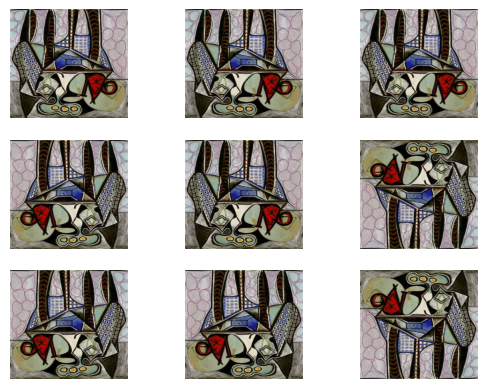

In [37]:
for images, _ in train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [38]:
data_augmentation = keras.Sequential([
    layers.RandomTranslation(0.3, 0.3),
])

2024-12-28 16:24:20.295138: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-12-28 16:24:20.295610: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


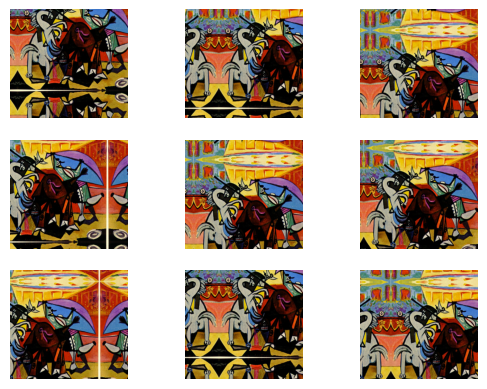

In [39]:
for images, _ in train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [40]:
data_augmentation = keras.Sequential([
    layers.RandomZoom(0.3),
])

2024-12-28 16:24:21.011673: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 61851136 bytes after encountering the first element of size 61851136 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


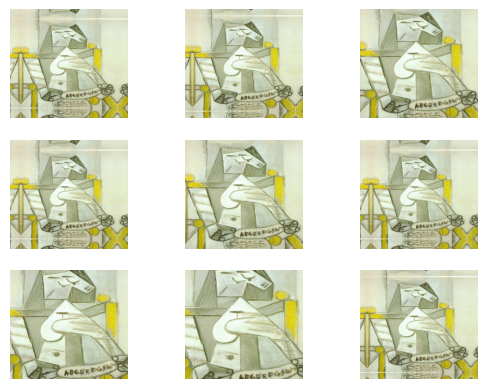

In [41]:
for images, _ in train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [42]:
data_augmentation = keras.Sequential([
    layers.Solarization(0.5),
])

2024-12-28 16:24:21.624057: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


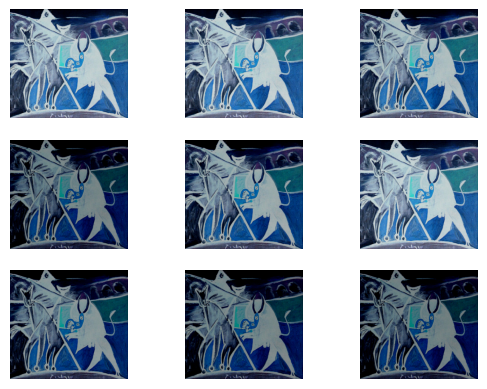

In [43]:
for images, _ in train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [44]:
data_augmentation = keras.Sequential([
    # layers.RandomZoom(0.3),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
])

2024-12-28 16:24:22.247378: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 61851136 bytes after encountering the first element of size 61851136 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


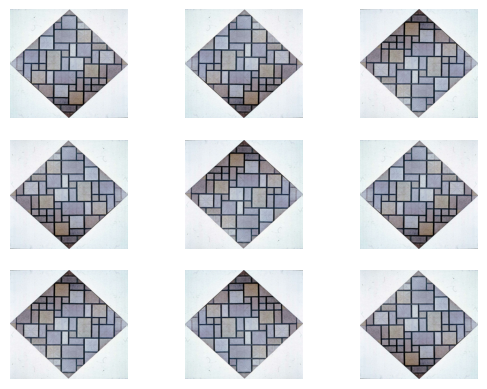

In [45]:
for images, _ in train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Undersampled dataset

### Model trainen zonder data augmentation

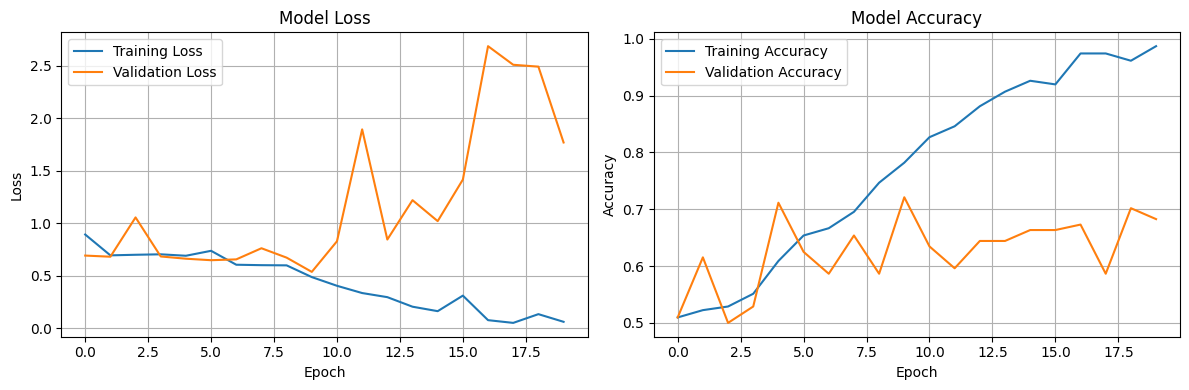

In [46]:
painters = ["Mondriaan", "Picasso"]
# dataset_dir = "/kaggle/input/schilderijen-datasets/undersampled_dataset"
dataset_dir = "undersampled_dataset"
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height)
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, verbose=0)

2024-12-28 16:25:32.883588: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step


2024-12-28 16:25:34.808607: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Accuracy:  0.5384615384615384
Recall:  0.5961538461538461
Precision:  0.5344827586206896
F1:  0.5636363636363636
ROC AUC:  0.5384615384615384


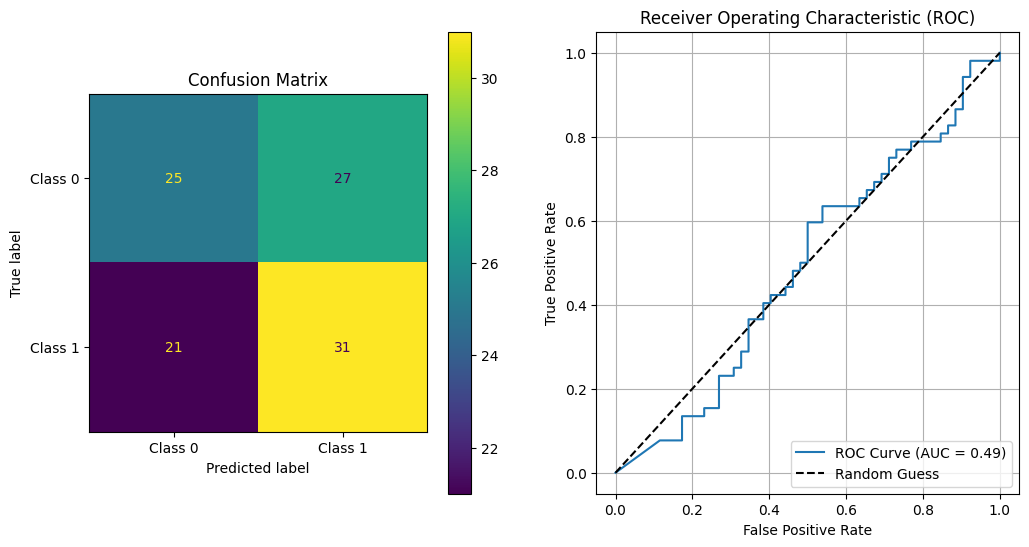

In [48]:
print_metrics(model, test)

### Model trainen met data augmentation

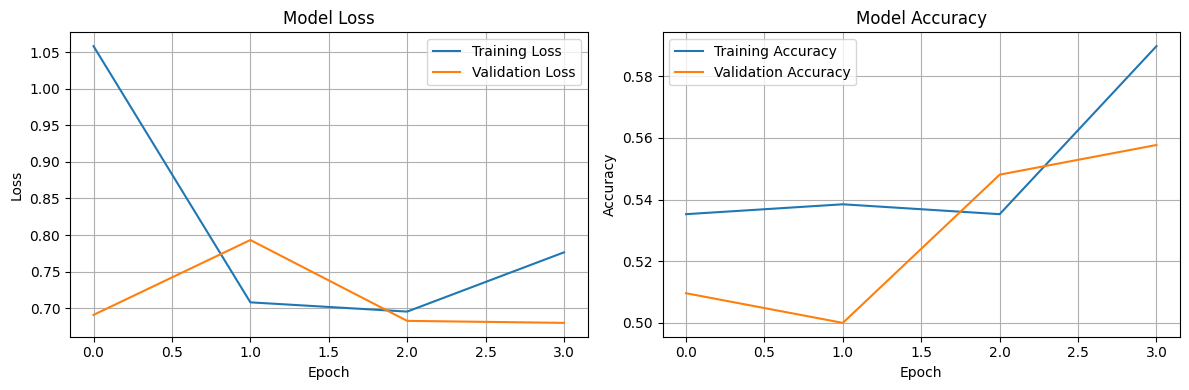

2024-12-28 16:25:58.825701: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


KeyboardInterrupt: 

In [49]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_undersampled_data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, verbose=0)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
Accuracy:  0.49038461538461536
Recall:  0.4423076923076923
Precision:  0.48936170212765956
F1:  0.46464646464646464
ROC AUC:  0.49038461538461536


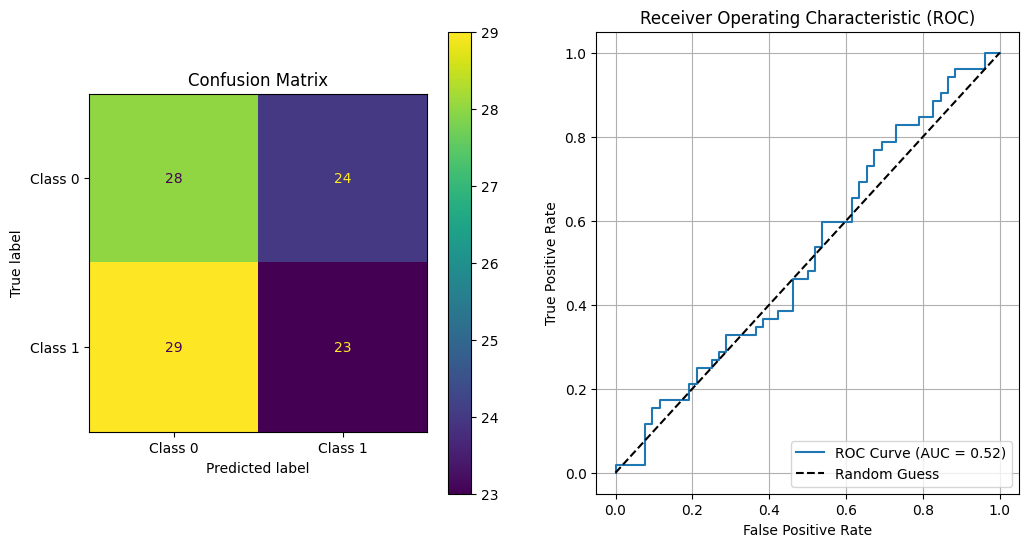

In [25]:
print_metrics(model, test)

## Oversampled dataset

### Model trainen zonder data augmentation

In [ ]:
dataset_dir = "oversampled_dataset"
# dataset_dir = "/kaggle/input/schilderijen-datasets/oversampled_dataset"
train, val, test = load_dataset(dataset_dir, painters, median_height, median_width, batch_size=16)
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_oversampled.keras", save_best_only=True, monitor="val_loss")]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks)

Found 1834 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Epoch 1/20


2024-12-28 16:18:59.779405: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,294,272]{3,2,1,0}, f32[16,64,292,270]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-12-28 16:18:59.964307: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.184966696s
Trying algorithm eng0{} for conv (f32[64,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,294,272]{3,2,1,0}, f32[16,64,292,270]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","c

115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.5153 - loss: 1.3263 - val_accuracy: 0.5164 - val_loss: 0.8235
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.6429 - loss: 0.8151 - val_accuracy: 0.5115 - val_loss: 1.0500
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - accuracy: 0.7121 - loss: 0.5999 - val_accuracy: 0.7262 - val_loss: 0.6976
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 24s 210ms/step - accuracy: 0.8072 - loss: 0.4564 - val_accuracy: 0.9000 - val_loss: 0.2996
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8776 - loss: 0.2939

2024-12-28 16:20:35.446426: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.8778 - loss: 0.2935 - val_accuracy: 0.9098 - val_loss: 0.2298
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.9303 - loss: 0.1893 - val_accuracy: 0.8803 - val_loss: 0.5916
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 33s 288ms/step - accuracy: 0.9725 - loss: 0.1042 - val_accuracy: 0.9328 - val_loss: 0.2903
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.9564 - loss: 0.1436 - val_accuracy: 0.9328 - val_loss: 0.4052
Epoch 9/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 29s 249ms/step - accuracy: 0.9917 - loss: 0.1106 - val_accuracy: 0.9082 - val_loss: 0.5619
Epoch 10/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step - accuracy: 0.9904 - loss: 0.0395 - val_accuracy: 0.9492 - val_loss: 0.3944
Epoch 11/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.9848 - loss: 0.0790 - val_accuracy: 0.9082 - val_loss: 0.7000
Epoch 12/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9860 - loss: 0.0529 - 

KeyboardInterrupt: 

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step
Accuracy:  0.5180327868852459
Recall:  0.49508196721311476
Precision:  0.5189003436426117
F1:  0.5067114093959731
ROC AUC:  0.5180327868852459


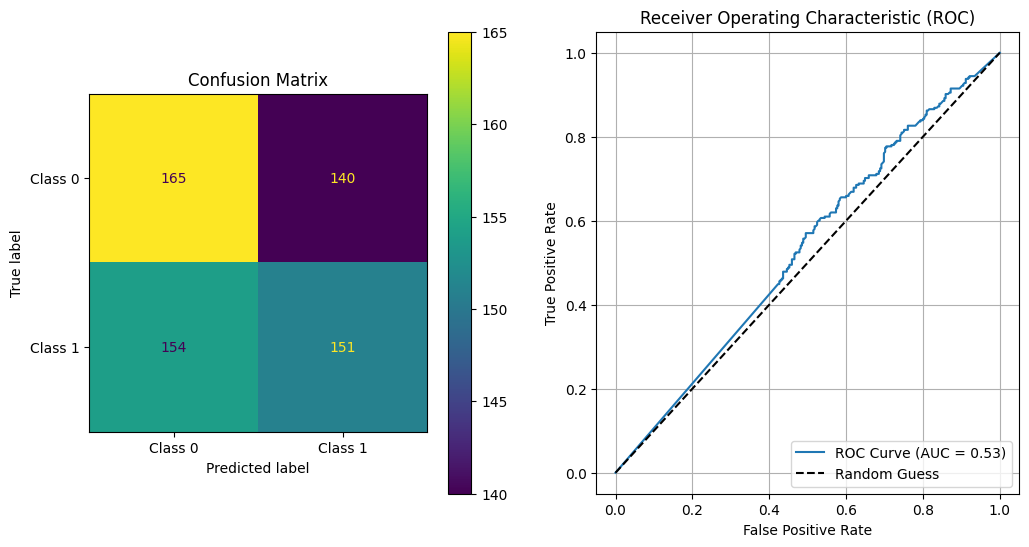

In [ ]:
print_metrics(model, test)

### Model trainen met data augmentation

In [153]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_oversampled_data_augmentation.keras", save_best_only=True, monitor="val_loss")]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - accuracy: 0.4981 - loss: 0.9719 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.5201 - loss: 0.6930 - val_accuracy: 0.6607 - val_loss: 0.6334
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.6452 - loss: 0.6513 - val_accuracy: 0.6934 - val_loss: 0.6563
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 0.6809 - loss: 0.6118 - val_accuracy: 0.6869 - val_loss: 0.5727
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.7167 - loss: 0.5744 - val_accuracy: 0.8262 - val_loss: 0.3761
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 26s 224ms/step - accuracy: 0.7759 - loss: 0.4920 - val_accuracy: 0.7836 - val_loss: 0.4682
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8246 - loss: 0.4064

2024-12-28 15:59:00.125389: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.8246 - loss: 0.4063 - val_accuracy: 0.8754 - val_loss: 0.2899
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 0.8111 - loss: 0.4047 - val_accuracy: 0.8426 - val_loss: 0.3255
Epoch 9/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 0.8573 - loss: 0.3280 - val_accuracy: 0.8590 - val_loss: 0.3323
Epoch 10/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 0.8610 - loss: 0.3475 - val_accuracy: 0.8279 - val_loss: 0.4353
Epoch 11/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.8870 - loss: 0.2902 - val_accuracy: 0.8656 - val_loss: 0.3618
Epoch 12/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 192ms/step - accuracy: 0.8995 - loss: 0.2505 - val_accuracy: 0.8869 - val_loss: 0.2643
Epoch 13/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.9070 - loss: 0.2657 - val_accuracy: 0.8705 - val_loss: 0.3029
Epoch 14/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 28s 246ms/step - accuracy: 0.8826 - loss: 0.2872 

39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step
Accuracy:  0.48032786885245904
Recall:  0.4721311475409836
Precision:  0.48
F1:  0.47603305785123967
ROC AUC:  0.480327868852459


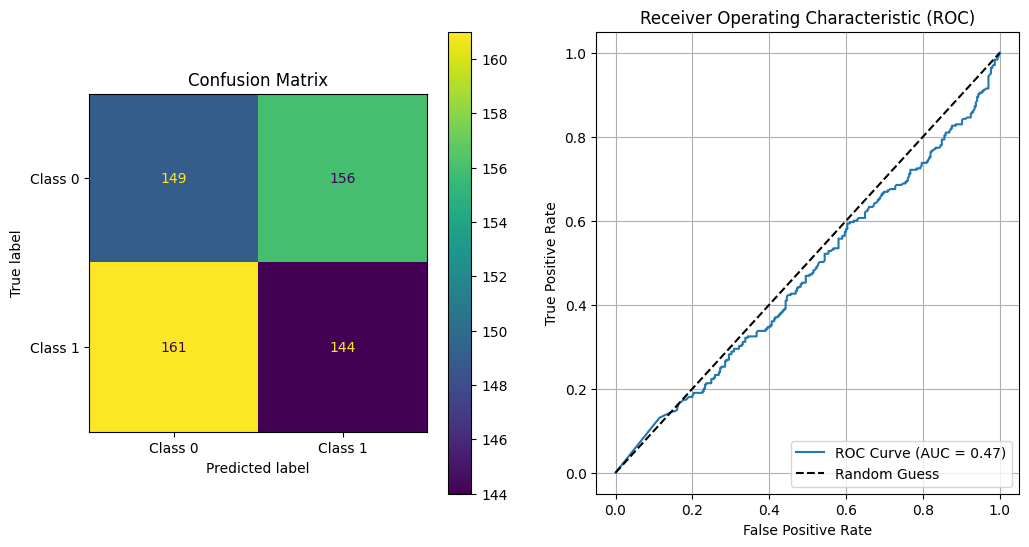

In [155]:
print_metrics(model, test)

## Imbalanced dataset

### Dataset laden

In [ ]:
dataset_dir = "imbalanced_dataset"
# dataset_dir = "/kaggle/input/schilderijen-datasets/imbalanced_dataset"
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height, batch_size=16)

Found 1115 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
Found 373 files belonging to 2 classes.


### Class weights bepalen

Mondriaan = 0, Picasso = 1

In [157]:
train.class_names

['Mondriaan', 'Picasso']

In [ ]:
class_counts = {}

for _, labels in train:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

total = sum(class_counts.values())
total, class_counts

(1115, {np.int32(1): 917, np.int32(0): 198})

In [159]:
mondriaan_count = class_counts.get(0, 0)  
picasso_count = class_counts.get(1, 0)   

weight_for_0 = float((1 / mondriaan_count) * (total / 2.0)) if mondriaan_count > 0 else 0
weight_for_1 = float((1 / picasso_count) * (total / 2.0)) if picasso_count > 0 else 0
class_weight = {0: weight_for_0, 1: weight_for_1}

class_weight

{0: 2.8156565656565657, 1: 0.6079607415485279}

: 

### Model trainen zonder data augmentation

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_imbalanced.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, class_weight=class_weight)

Epoch 1/20


2024-12-28 16:03:59.059984: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 82883136 bytes after encountering the first element of size 82883136 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step
Accuracy:  0.6792452830188679
Recall:  0.7639344262295082
Precision:  0.8321428571428572
F1:  0.7965811965811966
ROC AUC:  0.525906607054148


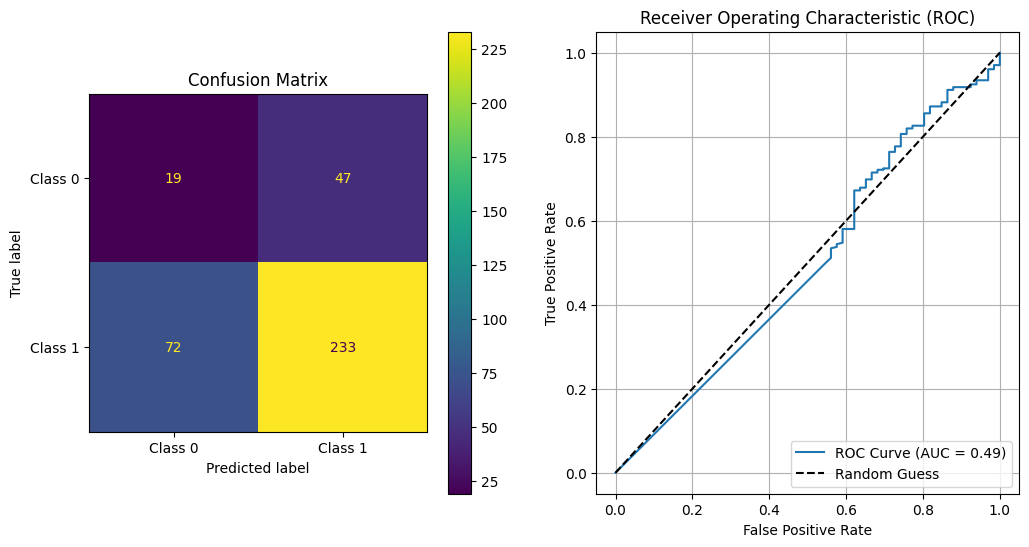

In [22]:
print_metrics(model, test)

### Model trainen met data augmentation

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_imbalanced_data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, class_weight=class_weight)

In [ ]:
print_metrics(model, test)

Image size bepalen

In [24]:
statistics = ["min", "25%", "median", "mean", "75%"]
interpolations = ["bilinear", "nearest", "bicubic", "area", "lanczos3", "lanczos5", "gaussian"]
dataset_dir = "/kaggle/input/schilderijen-datasets/imbalanced_dataset"
painters = ["Mondriaan", "Picasso"]

results = []

for statistic in statistics:
    width = int(stats.loc[f"{statistic}", "widths"])
    height = int(stats.loc[f"{statistic}", "heights"])
    for interpolation in interpolations:
        print(statistic, interpolation)
        train, val, test = load_dataset(dataset_dir, painters, width, height, batch_size=16, interpolation=interpolation)
        model = build_model(width, height)
        model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
        callbacks = [keras.callbacks.ModelCheckpoint(filepath="gridsearch_model.keras", save_best_only=True, monitor="val_loss")]
        history = model.fit(train, epochs=15, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

        y_pred_prob = model.predict(test)
        y_pred = np.where(y_pred_prob > 0.5, 1, 0)
        y_true = np.concatenate([y.numpy() for _, y in test], axis=0)
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        test_accuracy = accuracy_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_pred_prob)
        
        results.append({
            "statistic": statistic,
            "interpolation": interpolation,
            "width": width,
            "height": height,
            "train_accuracy": history.history['accuracy'][-1],
            "val_accuracy": history.history['val_accuracy'][-1],
            "test_accuracy": test_accuracy,
            "train_loss": history.history['loss'][-1],
            "val_loss": history.history['val_loss'][-1],
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "auc": auc_score
        })
        print(results[-1])

df = pd.DataFrame(results)

min bilinear
Found 1115 files belonging to 2 classes.
Found 373 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
{'statistic': 'min', 'interpolation': 'bilinear', 'width': 106, 'height': 108, 'train_accuracy': 0.9793722033500671, 'val_accuracy': 0.9249329566955566, 'test_accuracy': 0.6442048517520216, 'train_loss': 0.05422148108482361, 'val_loss': 0.2651461362838745, 'precision': 0.8145454545454546, 'recall': 0.7344262295081967, 'f1_score': 0.7724137931034483, 'auc': 0.4988077496274218}
min nearest
Found 1115 files belonging to 2 classes.
Found 373 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
{'statistic': 'min', 'interpolation': 'nearest', 'width': 106, 'height': 108, 'train_accuracy': 0.9829596281051636, 'val_accuracy': 0.9115281701087952, 'test_accuracy': 0.706199460916442, 'train_loss': 0.050010792911052704, 'val_loss': 0.3506341278553009, 'precision': 0.824

In [25]:
df.sort_values("test_accuracy", ascending=False).head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
5,min,lanczos5,106,108,0.971300,0.847185,0.787062,0.079654,1.327850,0.822857,0.944262,0.879389,0.487953
21,mean,bilinear,603,648,0.975785,0.954424,0.727763,0.135400,0.500894,0.833333,0.836066,0.834697,0.531495
12,25%,lanczos5,314,383,0.960538,0.930295,0.716981,0.094464,0.302923,0.831126,0.822951,0.827018,0.543443
16,median,bicubic,550,590,0.970404,0.919571,0.714286,0.077738,0.536489,0.832776,0.816393,0.824503,0.497640
13,25%,gaussian,314,383,0.959641,0.957105,0.711590,0.105894,0.199140,0.827815,0.819672,0.823723,0.512643


In [26]:
df.sort_values("f1_score", ascending=False).head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
5,min,lanczos5,106,108,0.971300,0.847185,0.787062,0.079654,1.327850,0.822857,0.944262,0.879389,0.487953
21,mean,bilinear,603,648,0.975785,0.954424,0.727763,0.135400,0.500894,0.833333,0.836066,0.834697,0.531495
12,25%,lanczos5,314,383,0.960538,0.930295,0.716981,0.094464,0.302923,0.831126,0.822951,0.827018,0.543443
16,median,bicubic,550,590,0.970404,0.919571,0.714286,0.077738,0.536489,0.832776,0.816393,0.824503,0.497640
6,min,gaussian,106,108,0.982063,0.949062,0.711590,0.077800,0.288918,0.825658,0.822951,0.824302,0.501664


In [31]:
df.sort_values("precision", ascending=False).head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
20,median,gaussian,550,590,0.943498,0.734584,0.568733,0.196751,2.123221,0.846890,0.580328,0.688716,0.512022
25,mean,lanczos3,603,648,0.968610,0.900804,0.708895,0.325899,0.460274,0.845614,0.790164,0.816949,0.567437
18,median,lanczos3,550,590,0.971300,0.871314,0.649596,0.132244,0.799231,0.843137,0.704918,0.767857,0.540686
33,75%,lanczos5,800,826,0.965919,0.892761,0.700809,0.381046,0.825638,0.841549,0.783607,0.811545,0.566865
19,median,lanczos5,550,590,0.958744,0.898123,0.644205,0.269686,0.634379,0.833977,0.708197,0.765957,0.521038


In [32]:
df.sort_values("recall", ascending=False).head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
5,min,lanczos5,106,108,0.971300,0.847185,0.787062,0.079654,1.327850,0.822857,0.944262,0.879389,0.487953
21,mean,bilinear,603,648,0.975785,0.954424,0.727763,0.135400,0.500894,0.833333,0.836066,0.834697,0.531495
12,25%,lanczos5,314,383,0.960538,0.930295,0.716981,0.094464,0.302923,0.831126,0.822951,0.827018,0.543443
22,mean,nearest,603,648,0.976682,0.938338,0.700809,0.112956,0.364941,0.814935,0.822951,0.818923,0.483159
6,min,gaussian,106,108,0.982063,0.949062,0.711590,0.077800,0.288918,0.825658,0.822951,0.824302,0.501664


In [33]:
df.sort_values("val_loss").head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
4,min,lanczos3,106,108,0.974888,0.935657,0.695418,0.086248,0.173565,0.811688,0.819672,0.815661,0.473597
13,25%,gaussian,314,383,0.959641,0.957105,0.711590,0.105894,0.199140,0.827815,0.819672,0.823723,0.512643
11,25%,lanczos3,314,383,0.973991,0.951743,0.679245,0.110439,0.259940,0.812081,0.793443,0.802653,0.465474
0,min,bilinear,106,108,0.979372,0.924933,0.644205,0.054221,0.265146,0.814545,0.734426,0.772414,0.498808
8,25%,nearest,314,383,0.952466,0.949062,0.700809,0.143429,0.266810,0.823333,0.809836,0.816529,0.500000


In [34]:
df.to_csv("image_size_gridsearch_result.csv")